## Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the use of DR-COSARC on real data sets.

In [5]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)
suppressMessages(library(hdf5r))

## Load the data

In [16]:
source("../conf_surv/utils_real_data.R")

# Available datasets:
# VALCT: Lung cancer trial data (137 obs, 6 vars, from survival::veteran).
# PBC: Liver disease data (137 obs, 6 vars, from survival::pbc, NAs imputed).
# GBSG: Breast cancer data (2232 obs, 7 vars, combined train/test).
# METABRIC: Breast cancer clinical data (1981 obs, 26 vars).

data.name <- "PBC"

data <- load_csv(data.name)
dim(data)

# Data features
num_features <- ncol(data) - 2

col.names <- c("time", "status", paste("X", 1:num_features, sep = ""))
colnames(data) <- col.names

[1] 418  19

In [65]:
## Relative calibration sample size
cal_prop = 0.2

## Relative test sample size
test_prop = 0.2

## Relative training sample size
train_prop = 1 - (cal_prop + test_prop)

# Split the dataset
split_result <- split_data(data, train_prop = train_prop, cal_prop = cal_prop, test_prop = test_prop, seed = 123)

# Access subsets
data.train <- split_result$train
data.cal <- split_result$cal
data.test <- split_result$test

# Subsample the training set
train_prop_keep = 0.5
data.train = data.train[sample(1:nrow(data.train), ceiling(train_prop_keep*nrow(data.train))),]

## Explore the data

In [66]:
# Summarize data under type-I censoring
data.train |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]))

Observations,Events,Proportion censored,Median observed time,Median observed event time
<int>,<dbl>,<dbl>,<dbl>,<dbl>
126,61,0.515873,1684,2644


We can also plot the Kaplan-Meier curve

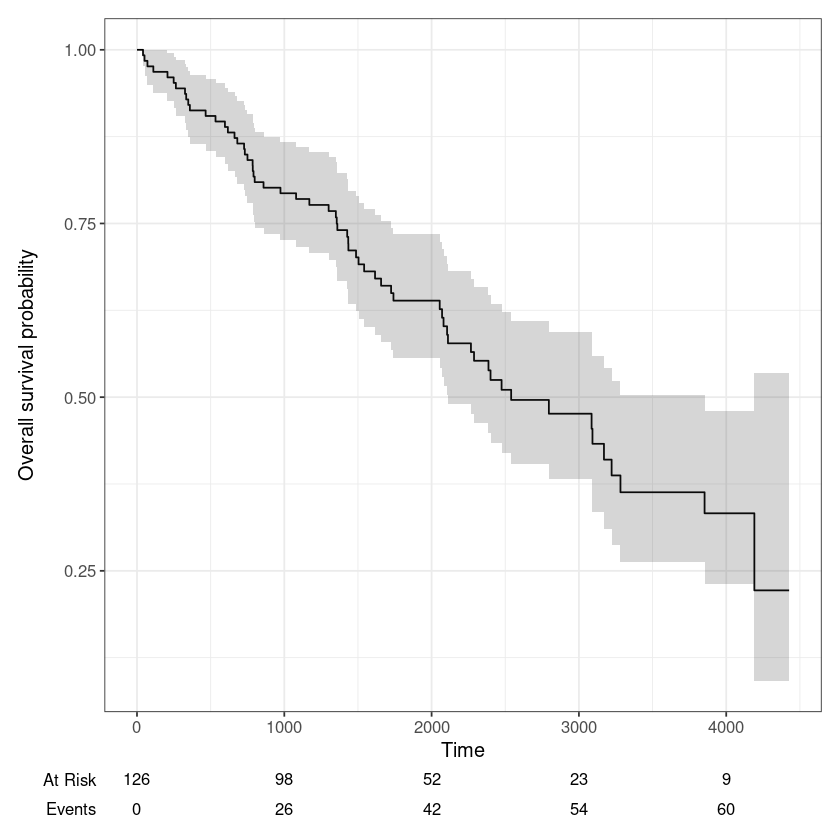

In [67]:
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Training (survival model)

Fit a survival model using the training data.

In [68]:
source("../conf_surv/utils_survival.R")

model_type = "cox"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

surv_model$fit(Surv(time, status) ~ ., data = data.train)

Let us now visualize the predicted survival curves for two individuals.

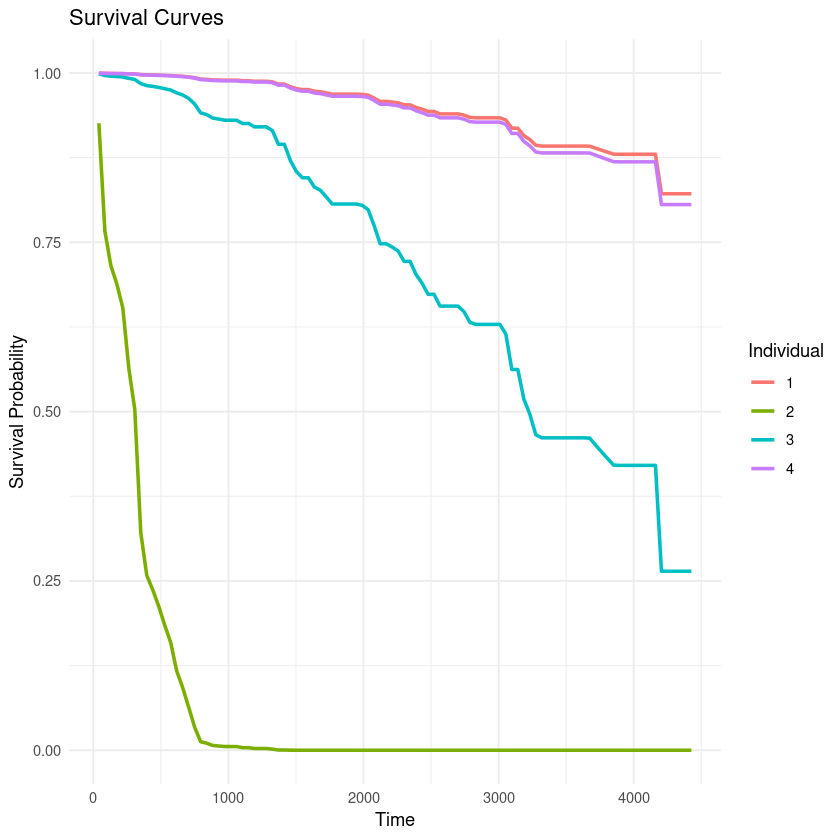

In [69]:
source("../conf_surv/utils_plotting.R")

idx.predict <- c(1:4)
predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

Predict survival time quantiles

In [70]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,3275.12121,4427.0000,4427.0000
Individual_2,85.30303,351.1212,661.2424
Individual_3,1370.09091,3230.8182,4427.0000
Individual_4,3186.51515,4427.0000,4427.0000


## Training (censoring model)

Let's start by visualizing the true censoring distribution

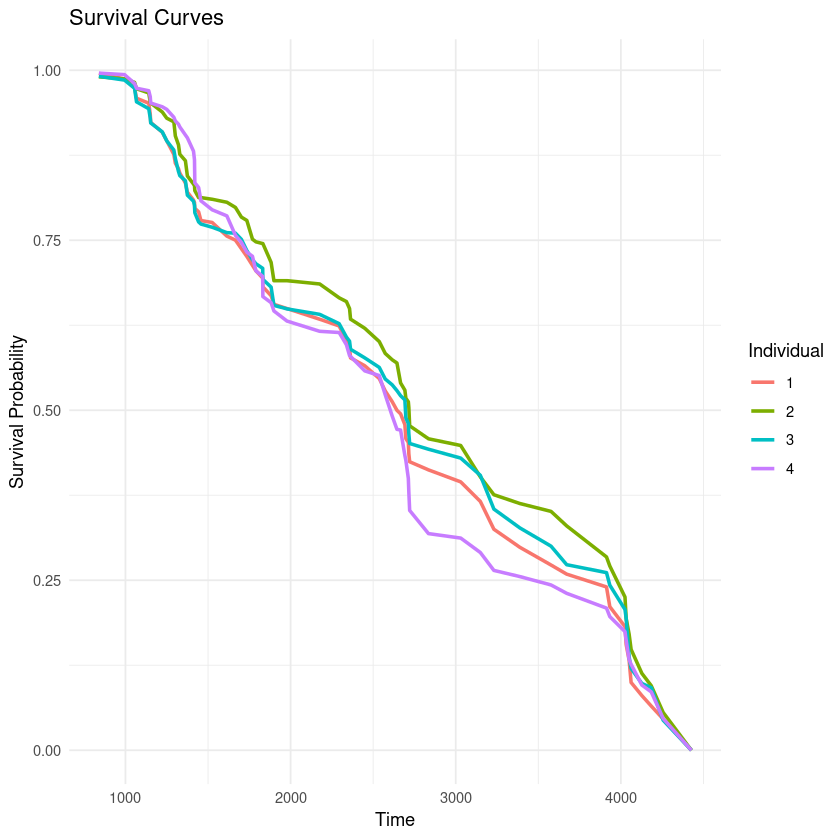

In [71]:
source("../conf_surv/utils_censoring.R")

# List of covariates to use for censoring model
# If we have prior information that some covariates are useless, we can drop them. This helps avoid overfitting, improving the performance of our prototype.
num_feat_censor <- num_features #10
use.covariates <- paste("X",1:min(num_features,num_feat_censor),sep="")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new(use_covariates=use.covariates)
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal", use_covariates=use.covariates)
#cens_base_model <- CoxphModelWrapper$new(use_covariates=use.covariates)
#cens_base_model <- randomForestSRC_SurvivalWrapper$new(use_covariates=use.covariates)

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
cens_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = cens_model$model$predict(data.cal[idx.predict,])
plot_survival_curves(pred_surv)

## Constructing lower prediction bounds with different methods

In [72]:
source("../conf_surv/utils_conformal.R")

# Nominal level
alpha <- 0.1

In [73]:
# No calibration (trust the survival model's output)
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                status=data.test$status,
                method="None")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
None,1277.215,NA,0.7951807,0.8674699


In [74]:
# Naive CQR
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                status=data.test$status,
                method="Naive CQR")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Naive CQR,659.9562,NA,0.9518072,0.9638554


In [75]:
source("../conf_surv/utils_decensoring.R")

## Fit the Kaplan-Meier survival model
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)
km_fit <- survfit(surv_object ~ 1)

# Qi et al.'s method (CQR with KM decensoring)
pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test$time, 
                pred.decensor,
                status=data.test$status,
                method="Qi et al.")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Qi et al.,937.341,NA,0.9156627,0.9277108


In [76]:
# Prototype (combined with Gui's approach)
pred.proto <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, 
                                cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.proto,
                status=data.test$status,
                method="Prototype (Gui)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Gui),667.4891,NA,0.939759,0.9518072


In [77]:
# Prototype (combined with Candes' approach)
pred.proto.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha,
                                       cutoffs="candes-fixed")

evaluate_bounds(data.test$time, 
                pred.proto.candes,
                status=data.test$status,
                method="Prototype (Candes)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Candes),428.722,NA,0.9518072,0.9638554


## Run simple experiments

In [ ]:
analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct nominal lower bound
    predictions$nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring (Qi et al.)
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
       
    # Apply prototype (Gui)
    predictions$prototype.gui <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

    # Apply prototype (Candes)
    predictions$prototype.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model)

In [ ]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], status=data.test$status,)
    
  cbind(Method = name, res)
}))
results